## Handling Big Data 

Here we will discuss tools to deal with `Big Data`. What counts as Big Data depends on the resources at hand, but people often seem to define it as 'Medium' data as when it can't fit in RAM, and Big Data when it can't fit in RAM and when it takes up a lot of disk space (e.g. on the order of Terabytes)

To deal with Medium or big data, there are useful libraries that enable parralelisation of tasks form numpy and xarray.

In [5]:
import os
import datetime
import xarray as xr
import dask
from pathlib import Path

notebook_dir = os.getcwd()
data_dir = str(Path(notebook_dir).parents[1] / 'data_samples' )
WEATHERBENCH_BUCKET = 'gs://weatherbench2/datasets/era5/1959-2022-full_37-6h-0p25deg_derived.zarr'

## Introduction to Dask

Dask is one of many computing libraries that uses 'lazy' evaluation to deal with large amounts of data. The key concept is that, rather than evaluating everything immediately, the program waits until explicitly asked to compute everything, and then it will try to make the computation as efficient as possible

Resources: 
https://tristansalles.github.io/EnviReef/6-addson/dask.html, 
https://docs.xarray.dev/en/stable/user-guide/dask.html

https://tutorial.xarray.dev/intermediate/xarray_and_dask.html

Let's start by creating a basic dask array

In [3]:
import dask.array as da

ones = da.ones((2000, 5000))
ones

dask.array<ones_like, shape=(2000, 5000), dtype=float64, chunksize=(2000, 5000), chunktype=numpy.ndarray>

In [4]:
# Specify the size of each chunk of data using chunks
darray = da.ones((2000, 5000), chunks=(1000, 1000))
darray

dask.array<ones_like, shape=(2000, 5000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [11]:
# We can perform operations on this array, but it won't actually do anything, just makes a note of the operations, and creates a graph
total_sum = darray.sum()
total_sum

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [12]:
# To actually get the answer, we can finally call compute
total_sum.compute()

10000000.0

From the xarray documentation

''A good rule of thumb is to create arrays with a minimum chunksize of at least one million elements (e.g., a 1000x1000 matrix). With large arrays (10+ GB), the cost of queueing up Dask operations can be noticeable, and you may need even larger chunksizes.''

## Loading a dataset with dask

Most of the time, we don't have to interact with dask directly, because xarray has great integration with dask.

We can simply specify the size of the chunks when opening a netcdf file, and under the hood it will store the data as a dask array

Simply specify how many chunks to separate your dimensions into. Since latitude and longitude aren't specified, the default is to have one chunk for each

In [8]:
ds = xr.open_dataset(os.path.join(data_dir, 'netcdf', 'E-OBS', 'UK_monthly.nc'), chunks={"time": 200, 'latitude': 30})

/Users/bobbyantonio/miniforge3/envs/python_workshop/lib/python3.10/site-packages/xarray/core/dataset.py:274: UserWarning: The specified chunks separate the stored chunks along dimension "latitude" starting at index 30. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


In [9]:
# Note that the data hasn't been loaded yet, it is a dask array, and just shows details of the data shape
ds['pp']

<xarray.DataArray 'pp' (time: 888, latitude: 38, longitude: 52)> Size: 7MB
dask.array<open_dataset-pp, shape=(888, 38, 52), dtype=float32, chunksize=(200, 30, 52), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 304B 49.62 49.88 50.12 ... 58.38 58.62 58.88
  * longitude  (longitude) float64 416B -10.88 -10.62 -10.38 ... 1.625 1.875
  * time       (time) datetime64[ns] 7kB 1950-01-16 1950-02-14 ... 2023-12-16
Attributes:
    standard_name:  air_pressure_at_sea_level
    long_name:      sea level pressure
    units:          hPa
    cell_methods:   time: mean

In [45]:
# you can also do this by loading it normally and using the .chunks() method

ds = xr.open_dataset(os.path.join(data_dir, 'netcdf', 'E-OBS', 'UK_monthly.nc'))
ds = ds.chunk({'time': 200})
ds['pp']

<xarray.DataArray 'pp' (time: 888, latitude: 38, longitude: 52)> Size: 7MB
dask.array<xarray-pp, shape=(888, 38, 52), dtype=float32, chunksize=(200, 38, 52), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 304B 49.62 49.88 50.12 ... 58.38 58.62 58.88
  * longitude  (longitude) float64 416B -10.88 -10.62 -10.38 ... 1.625 1.875
  * time       (time) datetime64[ns] 7kB 1950-01-16 1950-02-14 ... 2023-12-16
Attributes:
    standard_name:  air_pressure_at_sea_level
    long_name:      sea level pressure
    units:          hPa
    cell_methods:   time: mean

In [51]:
# Perform operations like on a regular xarray Dataset / Dataarray
# Nearly all xarray operations have been extended so that they are compatible with dask

final_ds = ds.isel(time=slice(0,100)).groupby('time.year').mean(...)

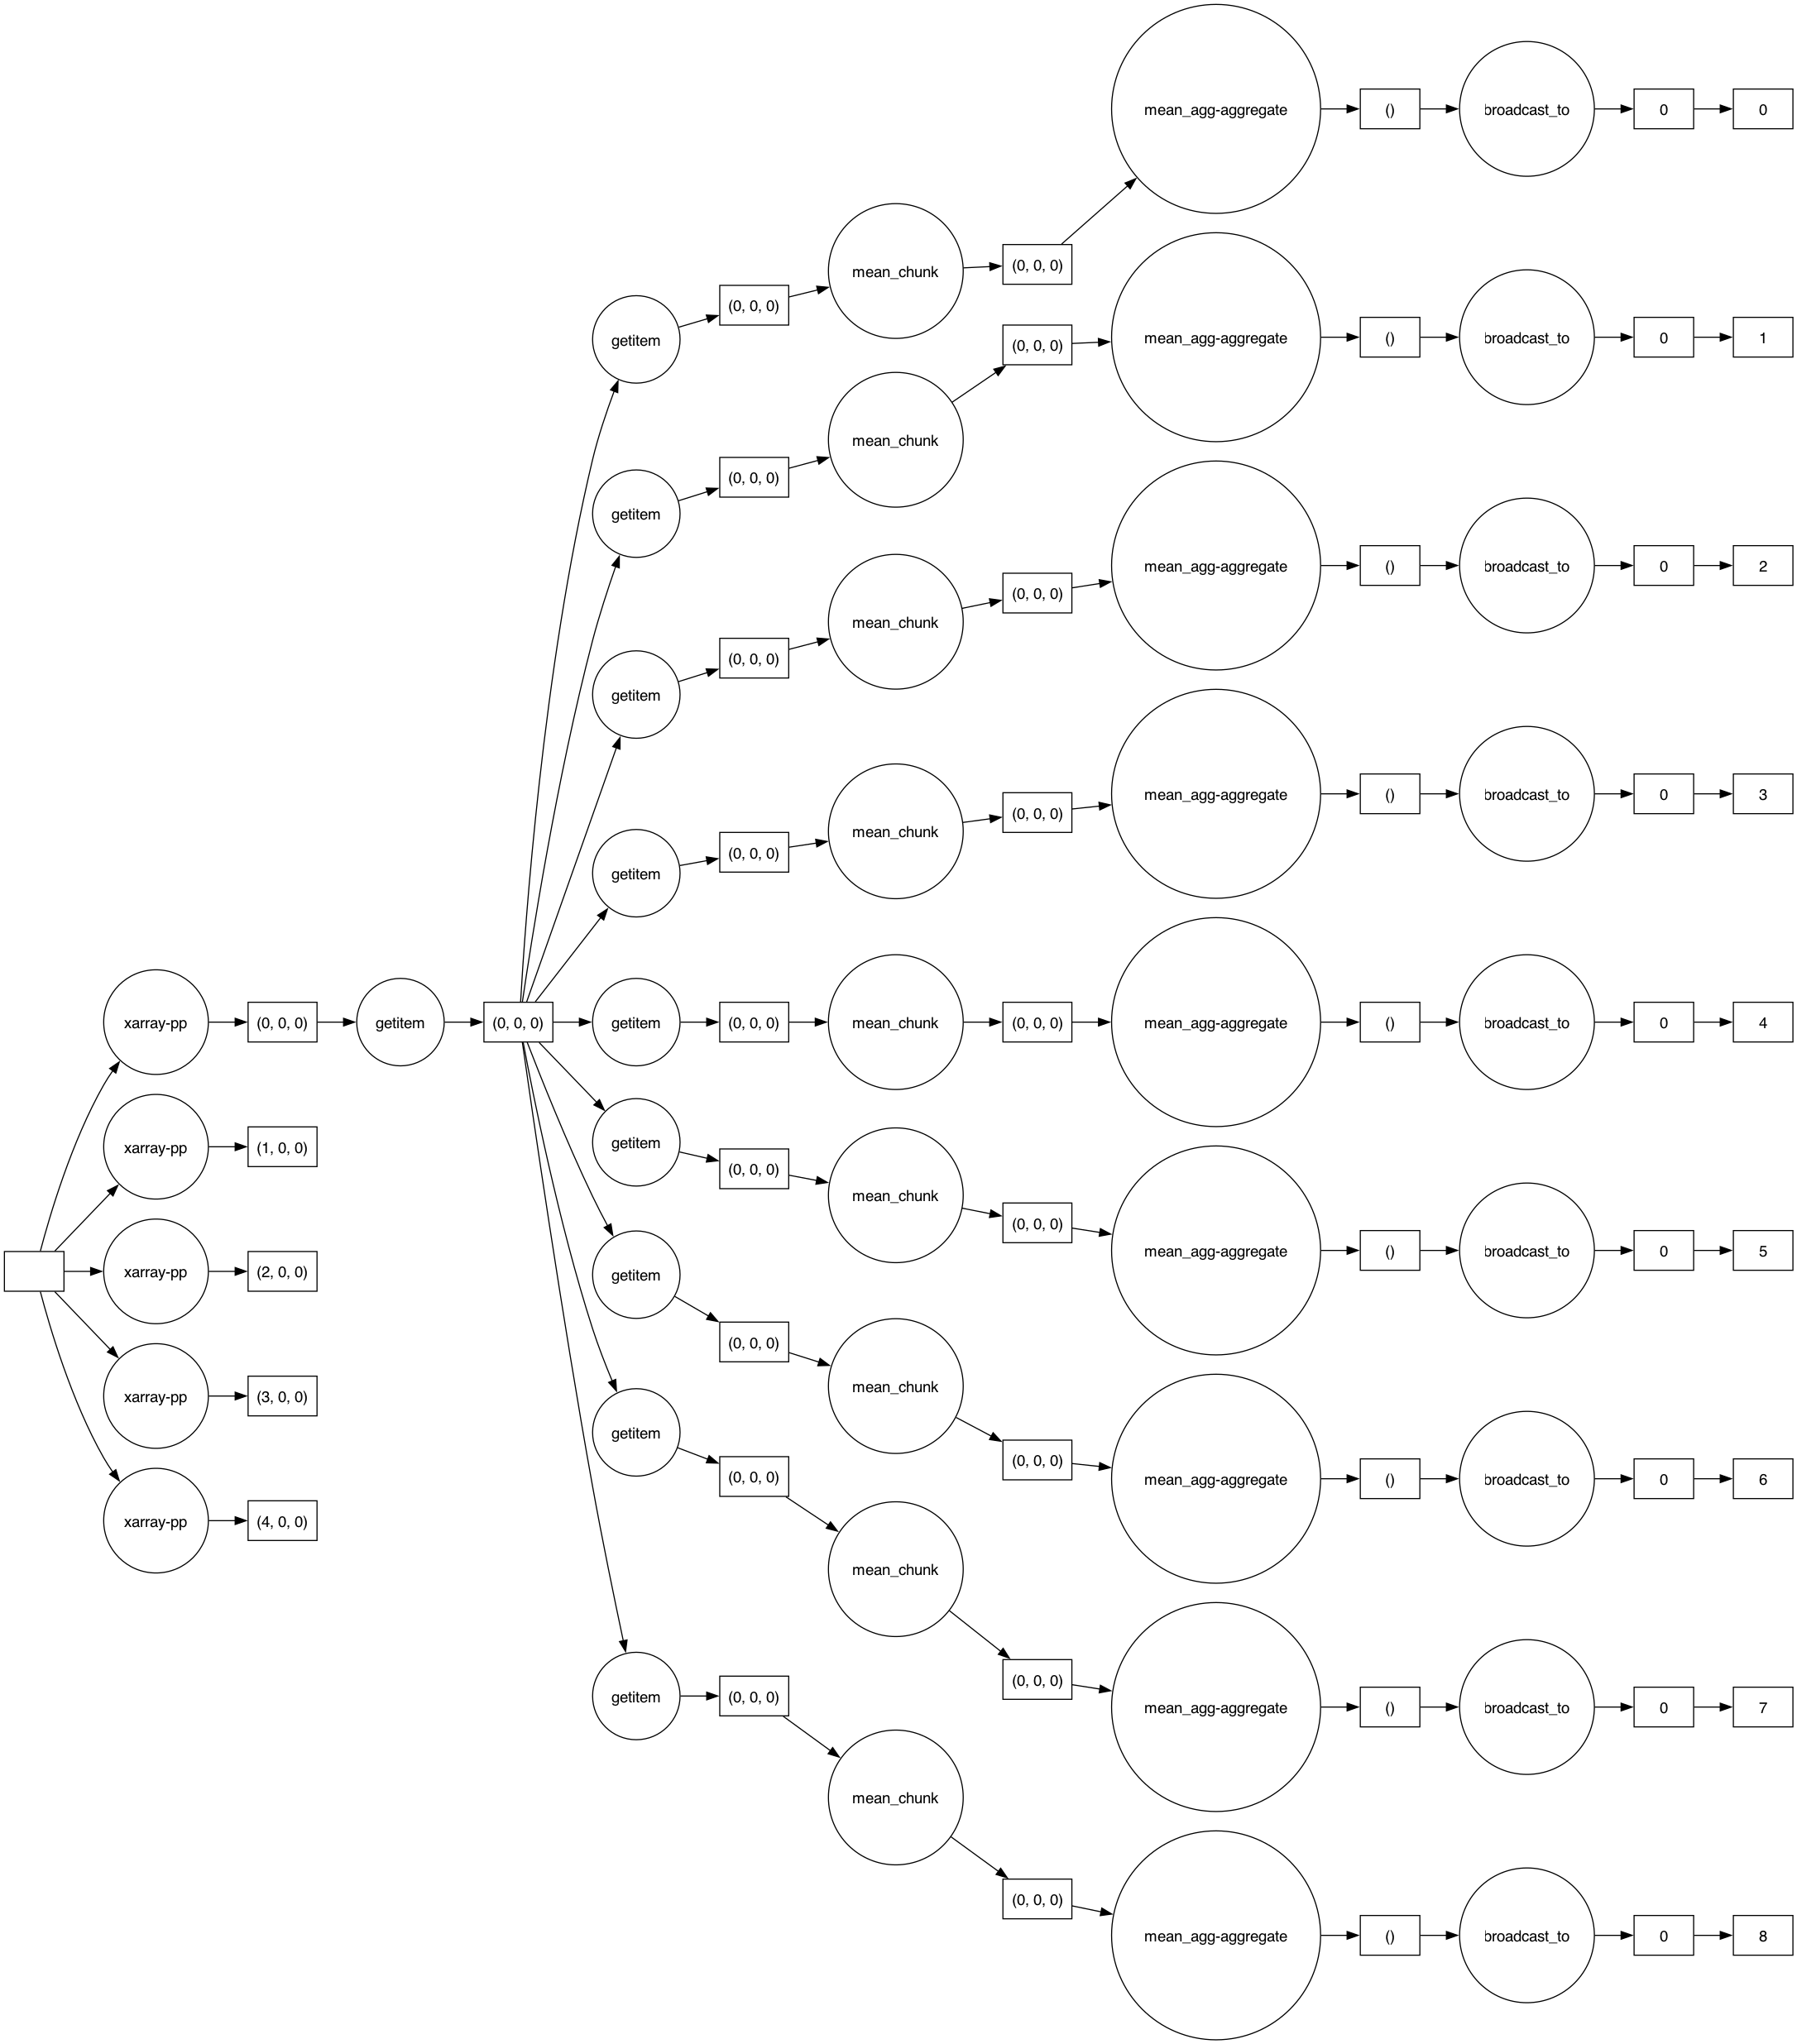

In [52]:
# Let's have a look at what operations the dataset will do. Note that only one branch of the 
dask.visualize(final_ds.pp.data, rankdir="LR")

In [51]:
# Finally when you are ready, call .compute() or .load() to make the computation actually happen
# The difference between load and compute: load operates in-place (i.e. the original dataset is overwritten) whereas compute returns the loaded dataset without overwriting the original

# so we can do this
computed_ds = final_ds.compute()

# Or alternatively overwrite final_ds with the in-memory dataset
final_ds.load()

# Alternatively, you can write the dataset to file, without having to load into memory, by just saving using ds.to_netcdf("filename.nc")

<xarray.Dataset>
Dimensions:  (year: 9)
Coordinates:
  * year     (year) int64 1950 1951 1952 1953 1954 1955 1956 1957 1958
Data variables:
    pp       (year) float32 1.011e+03 1.01e+03 1.014e+03 ... 1.014e+03 1.012e+03
    rr       (year) float32 3.427 3.367 2.571 2.68 3.698 2.818 3.084 3.146 3.189
    tg       (year) float32 9.107 8.816 8.949 9.584 ... 9.223 9.076 9.715 5.756
Attributes:
    Conventions:  CF-1.6
    frequency:    mon

In [38]:
# To access the data, calling .values will force the data into memory, whilst .data will keep it as a dask array
# So using .data can be useful if you have non-standard functions that act on your data
print(type(ds['pp'].values))
print(type(ds['pp'].data))

<class 'numpy.ndarray'>
<class 'dask.array.core.Array'>


## Multifile datasets


Here we will look at opening a dataset made up of many files, which is a common occurence. One way of doing this is to just loop over the files yourself, and combine them using e.g. `concat`. But there is also a handy function to do this in one step in xarray

In [10]:
# First we create a new multifile dataset in a new temporary directory 
uk_monthly_ds = xr.open_dataset(os.path.join(data_dir, 'netcdf', 'E-OBS', 'UK_monthly.nc'))

# Create a temporary directory, if it doesn't already exist
temp_dir_path = os.path.join(data_dir, 'tmp')
os.makedirs(temp_dir_path, exist_ok=True)


for n, t in enumerate(uk_monthly_ds.time.values):

    tmp_ds = uk_monthly_ds.sel(time=t)

    tmp_ds.to_netcdf(os.path.join(temp_dir_path, f"uk_monthly_{n}.nc"))

In [11]:
# Now we can load it easily using open_mfdataset
# First find all the relevant filepaths. There are many ways to do this, including a manual loop, but often glob is handy, as it uses a linux-like syntax

from glob import glob

relevant_fps = glob(os.path.join(temp_dir_path, 'uk_monthly_*.nc'))

print(relevant_fps[:10])

['/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_663.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_723.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_820.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_632.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_772.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_871.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_550.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_882.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_410.nc', '/Users/bobbyantonio/repos/iecdt_environmental_data_analysis/data_samples/tmp/uk_monthly_781.nc']


In [12]:
# now pass this list of filepaths into open_mfdataset
mutifile_dataset = xr.open_mfdataset(relevant_fps, 
                                     combine='nested', 
                                     concat_dim='time')

In [13]:
# This has created us a dataset made up of dask arrays
# Note by default it has chunked the data into one chunk per time step
mutifile_dataset['pp']

<xarray.DataArray 'pp' (time: 888, latitude: 38, longitude: 52)> Size: 7MB
dask.array<concatenate, shape=(888, 38, 52), dtype=float32, chunksize=(1, 38, 52), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 304B 49.62 49.88 50.12 ... 58.38 58.62 58.88
  * longitude  (longitude) float64 416B -10.88 -10.62 -10.38 ... 1.625 1.875
  * time       (time) datetime64[ns] 7kB 2005-04-15 2010-04-15 ... 1950-02-14
Attributes:
    standard_name:  air_pressure_at_sea_level
    long_name:      sea level pressure
    units:          hPa
    cell_methods:   time: mean

In [17]:
# Note that we had to use the combine='nested' because open_mfdataset tries to combine the arrays along one of the dimension coordinates, and each individual dataset doesn't have time as a dimension. This means that xarray can't figure our how it should join things together, so throws an error
try:
    mutifile_dataset = xr.open_mfdataset(relevant_fps)
except ValueError as e:
    print(e)

Could not find any dimension coordinates to use to order the datasets for concatenation


In [19]:
# If you don't specify a concat_dim value, then by defualt it uses xr.merge(). Since all the files contain the same variables, this causes an error too
try:
    mutifile_dataset = xr.open_mfdataset(relevant_fps,
                                        combine='nested')
except Exception as e:
    print(e)

conflicting values for variable 'pp' on objects to be combined. You can skip this check by specifying compat='override'.


In [22]:
# If you need to specify a particular chunking for the data, then it's best to specify the chunks when opening the data, rather than loading with the default
mutifile_dataset = xr.open_mfdataset(relevant_fps, 
                                     combine='nested', 
                                     concat_dim='time', 
                                     parallel=True, 
                                     chunks={'time': 4})

In [42]:
# TODO: using preprocess

## Using zarr arrays

In [2]:
# xarray has a handy function for arrays stored in zarr format (NOTE: this only works for zarr data that has been saved in a particular format)
# e.g. we can load ERA5 data from weatherbench
ds = xr.open_zarr(WEATHERBENCH_BUCKET)

In [4]:
# The result is a dataset where data is stored as dask arrays
ds['2m_temperature']

<xarray.DataArray '2m_temperature' (time: 92044, latitude: 721, longitude: 1440)> Size: 382GB
dask.array<open_dataset-2m_temperature, shape=(92044, 721, 1440), dtype=float32, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 736kB 1959-01-01 ... 2021-12-31T18:00:00
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

In [7]:
# As above, we can then subselect the data, and eventually call compute() to fetch the data. In this case, it's the 2-metre temperature on 1st January 2016 at 00:00am  a particular point. 

ds['2m_temperature'].sel(latitude=0).sel(longitude=0).sel(time=datetime.datetime(2016,1,1,0)).compute()

<xarray.DataArray '2m_temperature' ()> Size: 4B
array(300.20218, dtype=float32)
Coordinates:
    latitude   float32 4B 0.0
    longitude  float32 4B 0.0
    time       datetime64[ns] 8B 2016-01-01
Attributes:
    long_name:   2 metre temperature
    short_name:  t2m
    units:       K

## Visualising computations using the dask client

In [59]:
from dask.distributed import Client

# This piece of code is just for a correct dashboard link mybinder.org or other JupyterHub demos
import dask
import os


client = Client()
client

/Users/bobbyantonio/miniforge3/envs/python_workshop/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54216 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:54216/status,
Dashboard: http://127.0.0.1:54216/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54217,Workers: 4
Dashboard: http://127.0.0.1:54216/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:54231,Total threads: 2
Dashboard: http://127.0.0.1:54234/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:54220,


Just click on the Dashboard link above to access the dashboard

Then try running the below code and it will show you information about the run, such as CPU usage

In [64]:
xr.open_mfdataset(relevant_fps, 
                                     combine='nested', 
                                     concat_dim='time', 
                                     chunks={'time': 4}).groupby('time.year').mean(...).compute()

<xarray.Dataset> Size: 1kB
Dimensions:  (year: 74)
Coordinates:
  * year     (year) int64 592B 1950 1951 1952 1953 1954 ... 2020 2021 2022 2023
Data variables:
    pp       (year) float32 296B 1.013e+03 1.011e+03 ... 1.014e+03 1.012e+03
    rr       (year) float32 296B 2.882 2.876 2.374 2.216 ... 2.752 2.746 3.292
    tg       (year) float32 296B 8.691 8.475 8.407 9.248 ... 9.489 10.19 10.23
Attributes:
    Conventions:  CF-1.6
    frequency:    mon

In [65]:
# Finally, we need to close the client

client.close()